# Keypoints mapping aproach A

Parts of codes reference sources :https://aistudio.baidu.com/projectdetail/1301167

## Install pre-training model for human posture detection from Paddlehub

In [31]:
#! hub install human_pose_estimation_resnet50_mpii==1.1.1

In [2]:
import os
import cv2
import paddlehub as hub
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
%matplotlib inline

/opt/anaconda3/envs/paddle_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/paddle_env/lib/python3.8/site-packages/_distutils_hack/__init__.py:36: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Display images

In [3]:
# Display the specified path image
def show_img(img_path, size=8):
    im = imread(img_path)
    plt.figure(figsize=(size,size))
    plt.axis("off")
    plt.imshow(im)

# Display the image read by Opencv and convert the image channel to RGB format
def img_show_bgr(image,size=8):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(size,size))
    plt.imshow(image)
    plt.axis("off")
    plt.show() 

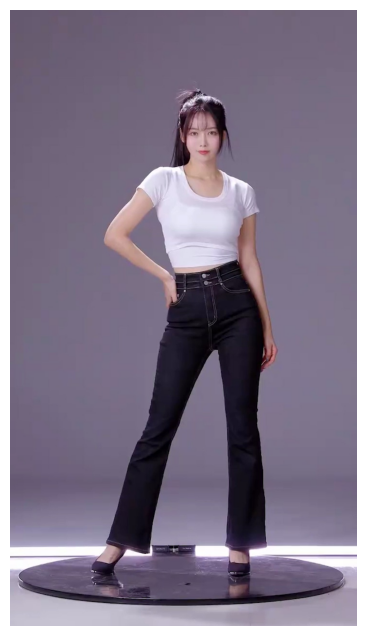

In [4]:
show_img('test/test.jpg')

In [5]:
pose_estimation = hub.Module(name="human_pose_estimation_resnet50_mpii")
result = pose_estimation.keypoint_detection(paths=['test/test.jpg'], visualization=True, output_dir="test/test_output")

image saved in test/test_output/test.jpg


In [6]:
result

[{'path': 'test/test.jpg',
  'data': OrderedDict([('left_ankle', [210, 1133]),
               ('left_knee', [300, 880]),
               ('left_hip', [367, 613]),
               ('right_hip', [472, 613]),
               ('right_knee', [480, 880]),
               ('right_ankle', [480, 1160]),
               ('pelvis', [420, 613]),
               ('thorax', [397, 373]),
               ('upper_neck', [397, 333]),
               ('head_top', [397, 173]),
               ('right_wrist', [315, 546]),
               ('right_elbow', [210, 466]),
               ('right_shoulder', [315, 346]),
               ('left_shoulder', [487, 386]),
               ('left_elbow', [495, 520]),
               ('left_wrist', [532, 666])])}]

## Adjust Keypoints

In [7]:
def adjust_keypoints_function(result):
    keypoints = result[0]['data']
    chest = keypoints['thorax']
    pelvis = keypoints['pelvis']
    left_hip = keypoints['left_hip']
    right_hip = keypoints ['right_hip']
    left_shoulder =keypoints ['left_shoulder']
    right_shoulder =keypoints ['right_shoulder']

    # Calculate the new longitudinal coordinate by multiplying the distance from the pelvis to the chest by 1.5
    new_pelvis_y = chest[1] + (pelvis[1] - chest[1]) * 1.5
    new_pelvis = [pelvis[0], int(new_pelvis_y)]
    keypoints['pelvis'] = new_pelvis

    new_left_hip_y = left_shoulder[1] + (left_hip[1] - left_shoulder[1]) * 1.5
    new_left_hip = [left_hip[0], int(new_left_hip_y)]
    
    new_right_hip_y = right_shoulder[1] + (right_hip[1] - right_shoulder[1]) * 1.5
    new_right_hip = [right_hip[0], int(new_right_hip_y)]

    keypoints['left_hip'] = new_right_hip
    keypoints['right_hip'] = new_left_hip
    
    left_elbow = keypoints['left_elbow']
    right_elbow = keypoints ['right_elbow']
    left_wrist =keypoints ['left_wrist']
    right_wrist =keypoints ['right_wrist']
    
    new_left_wrist_y = left_elbow[1] + (left_wrist[1] - left_elbow[1]) * 1.5
    new_left_wrist = [left_wrist[0], int(new_left_wrist_y)]
    
    new_right_wrist_y = right_elbow[1] + (right_wrist[1] - right_elbow[1]) * 1.5
    new_right_wrist = [right_wrist[0], int(new_right_wrist_y)]

    keypoints['left_wrist'] = new_left_wrist
    keypoints['right_wrist'] = new_right_wrist
    
    new_left_knee = keypoints['right_knee']
    new_right_knee = keypoints['left_knee']
    new_left_ankle = keypoints['right_ankle']
    new_right_ankle = keypoints['left_ankle']
    
    keypoints['left_knee'] = new_left_knee
    keypoints['right_knee'] = new_right_knee

    keypoints['left_ankle'] = new_left_ankle
    keypoints['right_ankle'] = new_right_ankle

    return keypoints

In [8]:
adjust_keypoints_test = adjust_keypoints_function(result)

In [9]:
adjust_keypoints_test

OrderedDict([('left_ankle', [480, 1160]),
             ('left_knee', [480, 880]),
             ('left_hip', [472, 746]),
             ('right_hip', [367, 726]),
             ('right_knee', [300, 880]),
             ('right_ankle', [210, 1133]),
             ('pelvis', [420, 733]),
             ('thorax', [397, 373]),
             ('upper_neck', [397, 333]),
             ('head_top', [397, 173]),
             ('right_wrist', [315, 586]),
             ('right_elbow', [210, 466]),
             ('right_shoulder', [315, 346]),
             ('left_shoulder', [487, 386]),
             ('left_elbow', [495, 520]),
             ('left_wrist', [532, 739])])

## Make a heatmap

This function is wrote by ChatGpt.

In [10]:
def generate_custom_heatmap(image_path, keypoints, output_path):
   
    image = cv2.imread(image_path)
    heatmap = np.zeros_like(image)  

    color = (255, 100, 0) 
    radius = 10 
    thickness = -1 

    for key, coord in keypoints.items():
        cv2.circle(heatmap, (coord[0], coord[1]), radius, color, thickness)

    combined_image = cv2.addWeighted(image, 1, heatmap, 1, 0)
  
    cv2.imwrite(output_path, combined_image)
   
    plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

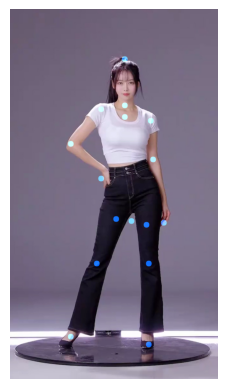

In [11]:
image_path = 'test/test.jpg'
output_path = 'test/custom_heatmap.jpg'
generate_custom_heatmap(image_path, adjust_keypoints_test, output_path)

## Keypoint mapping

In [12]:
body_img_path_map = {
    "right_hip" : "puppet_parts/rightshorts.png",
    "right_knee" : "puppet_parts/rightleg.png",
    "left_hip" : "puppet_parts/leftshorts.png",
    "left_knee" : "puppet_parts/leftleg.png",
    "left_elbow" : "puppet_parts/leftarm.png",
    "left_wrist" : "puppet_parts/lefthand.png",
    "right_elbow" : "puppet_parts/rightarm.png",
    "right_wrist" : "puppet_parts/righthand.png",
    "head" : "puppet_parts/head.png",
    "body" : "puppet_parts/body.png"
}

In [13]:
def get_true_angel(value):
    return value/np.pi*180

def get_angle(x1, y1, x2, y2):
    dx = abs(x1- x2)
    dy = abs(y1- y2)
    result_angele = 0
    if x1 == x2:
        if y1 > y2:
            result_angele = 180
    else:
        if y1!=y2:
            the_angle = int(get_true_angel(np.arctan(dx/dy)))
        if x1 < x2:
            if y1>y2:
                result_angele = -(180 - the_angle)
            elif y1<y2:
                result_angele = -the_angle
            elif y1==y2:
                result_angele = -90
        elif x1 > x2:
            if y1>y2:
                result_angele = 180 - the_angle
            elif y1<y2:
                result_angele = the_angle
            elif y1==y2:
                result_angele = 90
    
    if result_angele<0:
        result_angele = 360 + result_angele
    return result_angele

def rotate_bound(image, angle, key_point_y):
    # Get the size of the image
    (h,w) = image.shape[:2]
    # Get centre of rotation
    (cx,cy) = (w/2,h/2)
    # Ensure that the key point must be on the y-axis of the centre
    (kx,ky) = cx, key_point_y
    d = abs(ky - cy)
    
    # Set the rotation matrix
    M = cv2.getRotationMatrix2D((cx,cy), -angle, 1.0)
    cos = np.abs(M[0,0])
    sin = np.abs(M[0,1])
    
    # Calculate the new boundary after image rotation
    nW = int((h*sin)+(w*cos))
    nH = int((h*cos)+(w*sin))
    
    # Calculate the relative displacement after rotation
    move_x = nW/2 + np.sin(angle/180*np.pi)*d 
    move_y = nH/2 - np.cos(angle/180*np.pi)*d
    
    # Adjust the shift distance of the rotation matrix (t_{x}, t_{y})
    M[0,2] += (nW/2) - cx
    M[1,2] += (nH/2) - cy

    return cv2.warpAffine(image,M,(nW,nH)), int(move_x), int(move_y)

def get_distences(x1, y1, x2, y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

In [14]:
def append_img_by_sk_points(img, append_img_path, key_point_y, first_point, second_point, append_img_reset_width=None,
                                        append_img_max_height_rate=1, middle_flip=False, append_img_max_height=None):

    append_image = cv2.imdecode(np.fromfile(append_img_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

    sk_height = int(get_distences(first_point[0], first_point[1], second_point[0], second_point[1])*append_img_max_height_rate)
    if append_img_max_height:
        sk_height = min(sk_height, append_img_max_height)

    sk_width = int(sk_height/append_image.shape[0]*append_image.shape[1]) if append_img_reset_width is None else int(append_img_reset_width)
    if sk_width <= 0:
        sk_width = 1
    if sk_height <= 0:
        sk_height = 1

    key_point_y_new = int(key_point_y/append_image.shape[0]*append_image.shape[1])
    append_image = cv2.resize(append_image, (sk_width, sk_height))

    img_height, img_width, _ = img.shape

    if middle_flip:
        middle_x = int(img_width/2)
        if first_point[0] < middle_x and second_point[0] < middle_x:
            append_image = cv2.flip(append_image, 1)

    angle = get_angle(first_point[0], first_point[1], second_point[0], second_point[1])
    append_image, move_x, move_y = rotate_bound(append_image, angle=angle, key_point_y=key_point_y_new)
    app_img_height, app_img_width, _ = append_image.shape
    
    zero_x = first_point[0] - move_x
    zero_y = first_point[1] - move_y

    (b, g, r, a) = cv2.split(append_image)
    for i in range(0, r.shape[0]):
        for j in range(0, r.shape[1]):
            if a[i][j] > 0 and not (r[i][j] > 240 and g[i][j] > 240 and b[i][j] > 240) and 0 <= zero_y + i < img_height and 0 <= zero_x + j < img_width:
                img[zero_y + i][zero_x + j] = [b[i][j], g[i][j], r[i][j]]
    return img

In [15]:
def get_combine_img(img_path, pose_estimation=pose_estimation, body_img_path_map=body_img_path_map, backgroup_img_path= 'test/background.jpg'):
    
    result = pose_estimation.keypoint_detection(paths=[img_path])
    adjust_keypoints = adjust_keypoints_function(result)
   
    image=cv2.imread(img_path)

    backgroup_image = cv2.imread(backgroup_img_path)
    image_flag = cv2.resize(backgroup_image, (image.shape[1], image.shape[0]))

    min_width = int(get_distences(adjust_keypoints['head_top'][0], adjust_keypoints['head_top'][1],
                adjust_keypoints['pelvis'][0], adjust_keypoints['upper_neck'][1])/3)
    
    append_img_reset_width = max(int(get_distences(adjust_keypoints['pelvis'][0], adjust_keypoints['pelvis'][1],
                                            adjust_keypoints['left_hip'][0], adjust_keypoints['right_hip'][1])*1.6), min_width)
    image_flag = append_img_by_sk_points(image_flag, body_img_path_map['right_hip'], key_point_y=10, first_point=adjust_keypoints['right_hip'],
                                        second_point=adjust_keypoints['right_knee'], append_img_reset_width=append_img_reset_width)

    append_img_reset_width = max(int(get_distences(adjust_keypoints['pelvis'][0], adjust_keypoints['pelvis'][1],
                                            adjust_keypoints['left_hip'][0], adjust_keypoints['right_hip'][1])*1.5), min_width)
    image_flag = append_img_by_sk_points(image_flag, body_img_path_map['right_knee'], key_point_y=10, first_point=adjust_keypoints['right_knee'],
                                            second_point=adjust_keypoints['right_ankle'], append_img_reset_width=append_img_reset_width)

    append_img_reset_width = max(int(get_distences(adjust_keypoints['pelvis'][0], adjust_keypoints['pelvis'][1],
                                            adjust_keypoints['left_hip'][0], adjust_keypoints['left_hip'][1])*1.6), min_width)
    image_flag = append_img_by_sk_points(image_flag, body_img_path_map['left_hip'], key_point_y=0, first_point=adjust_keypoints['left_hip'],
                                        second_point=adjust_keypoints['left_knee'], append_img_reset_width=append_img_reset_width)

    append_img_reset_width = max(int(get_distences(adjust_keypoints['pelvis'][0], adjust_keypoints['pelvis'][1],
                                            adjust_keypoints['left_hip'][0], adjust_keypoints['left_hip'][1])*1.5), min_width)
    image_flag = append_img_by_sk_points(image_flag, body_img_path_map['left_knee'], key_point_y=10, first_point=adjust_keypoints['left_knee'],
                                            second_point=adjust_keypoints['left_ankle'], append_img_reset_width=append_img_reset_width)

    image_flag = append_img_by_sk_points(image_flag, body_img_path_map['right_elbow'], key_point_y=25, first_point=adjust_keypoints['right_shoulder'],
                                        second_point=adjust_keypoints['right_elbow'], append_img_max_height_rate=1.1)

    append_img_max_height = int(get_distences(adjust_keypoints['right_shoulder'][0], adjust_keypoints['right_shoulder'][1],
                                            adjust_keypoints['right_elbow'][0], adjust_keypoints['right_elbow'][1])*2)
    image_flag = append_img_by_sk_points(image_flag, body_img_path_map['right_wrist'], key_point_y=10, first_point=adjust_keypoints['right_elbow'],
                                            second_point=adjust_keypoints['right_wrist'], append_img_max_height_rate=1.5, 
                                            append_img_max_height=append_img_max_height)

    image_flag = append_img_by_sk_points(image_flag, body_img_path_map['left_elbow'], key_point_y=25, first_point=adjust_keypoints['left_shoulder'], 
                                        second_point=adjust_keypoints['left_elbow'],  append_img_max_height_rate=1.1)

    append_img_max_height = int(get_distences(adjust_keypoints['left_shoulder'][0], adjust_keypoints['left_shoulder'][1],
                                        adjust_keypoints['left_elbow'][0], adjust_keypoints['left_elbow'][1])*2)
    image_flag = append_img_by_sk_points(image_flag, body_img_path_map['left_wrist'], key_point_y=10, first_point=adjust_keypoints['left_elbow'],
                                        second_point=adjust_keypoints['left_wrist'], append_img_max_height_rate=1.5, 
                                         append_img_max_height=append_img_max_height)

    image_flag = append_img_by_sk_points(image_flag, body_img_path_map['head'], key_point_y=10, first_point=adjust_keypoints['head_top'],
                    second_point=adjust_keypoints['thorax'], append_img_max_height_rate=1.1, middle_flip=True)

    append_img_reset_width = max(int(get_distences(adjust_keypoints['left_shoulder'][0], adjust_keypoints['left_shoulder'][1],
                                            adjust_keypoints['right_shoulder'][0], adjust_keypoints['right_shoulder'][1])), min_width*3)
    image_flag = append_img_by_sk_points(image_flag, body_img_path_map['body'], key_point_y=20, first_point=adjust_keypoints['thorax'],
                    second_point=adjust_keypoints['pelvis'], append_img_reset_width=append_img_reset_width, append_img_max_height_rate=1.1)

    result_img =  np.concatenate((image, image_flag), axis=1) 

    return result_img

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


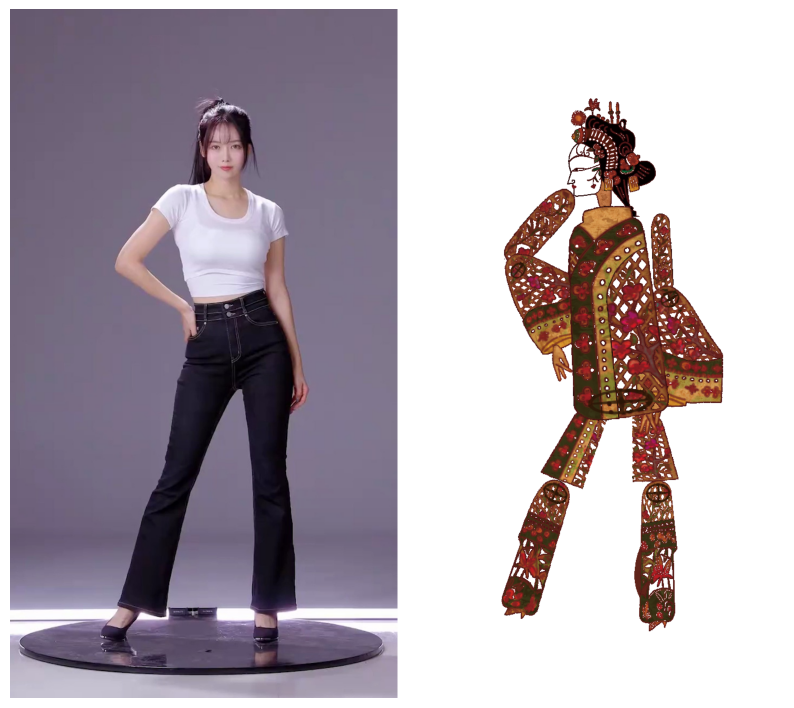

In [16]:
pos_img_path = 'test/test.jpg'
result_img =  get_combine_img(pos_img_path, pose_estimation, body_img_path_map)
img_show_bgr(result_img, size=10)

## Compositing Generated Video and Audio

In [17]:
input_video = 'test.mp4'

In [195]:
def transform_video_to_image(video_file_path, img_path):

    video_capture = cv2.VideoCapture(video_file_path)
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    count = 0
    while(True):
        ret, frame = video_capture.read() 
        if ret:
            cv2.imwrite(img_path + '%d.jpg' % count, frame)
            count += 1
        else:
            break
    video_capture.release()
    return fps

In [ ]:
fps = transform_video_to_image(input_video, 'test/test_video/')

In [18]:
def analysis_pose(input_frame_path, output_frame_path, is_print=True):
    file_items = os.listdir(input_frame_path)
    file_len = len(file_items)
    for i, file_item in enumerate(file_items):
        if is_print:
            print(i+1,'/', file_len, ' ', os.path.join(output_frame_path, file_item))
        combine_img = get_combine_img(os.path.join(input_frame_path, file_item))
        cv2.imwrite(os.path.join(output_frame_path, file_item), combine_img)

In [19]:
analysis_pose('test/test_video', 'test/test_video_results_A', is_print=False)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [20]:
def combine_image_to_video(comb_path, output_file_path, fps=30, is_print=False):

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')    
    
    file_items = os.listdir(comb_path)
    file_len = len(file_items)
    # print(comb_path, file_items)
    if file_len > 0 :
        temp_img = cv2.imread(os.path.join(comb_path, file_items[0]))
        img_height, img_width = temp_img.shape[0], temp_img.shape[1]
        
        out = cv2.VideoWriter(output_file_path, fourcc, fps, (img_width, img_height))

        for i in range(file_len):
            pic_name = os.path.join(comb_path, str(i)+".jpg")
            if is_print:
                print(i+1,'/', file_len, ' ', pic_name)
            img = cv2.imread(pic_name)
            out.write(img)
        out.release()

In [22]:
combine_image_to_video('test/test_video_results_A', 'test/test_video_results_A.mp4', fps =30)

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
